<a href="https://colab.research.google.com/github/AriSalassa/vision-por-computadora-2/blob/master/2/VPC2_Clase_2_Tarea_3co2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Utilizando el dataset de señas de manos, crear una red neuronal con caracteristicas similares a las vistas en clase y entrenarla hasta obtener un accuracy de, como minimo, 85% evitando sobreentrenamiento. Aplicar las técnicas de data augmentation que consideren necesarias.

---
El dataset es un conjunto de imagenes de una mano realizando figuras de numeros del 0 al 5. El objetivo es clasificar a que digito corresponde cada imagen.

<img src="https://drive.google.com/uc?export=view&id=1Tm9arSkvypYpXzANQo4C2DtMWzkjA4hO" style="width:800px;height:300px;">


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
!unrar x "/content/drive/MyDrive/ColabNotebooks/dataset_manos.rar" "/content/sample_data"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/ColabNotebooks/dataset_manos.rar

Extracting  /content/sample_data/test_signs.h5                            10%  OK 
Extracting  /content/sample_data/train_signs.h5                           68% 99%  OK 
All OK


In [5]:
def load_dataset(base_path = '/content/sample_data/'):
    train_dataset = h5py.File(base_path + 'train_signs.h5', "r")
    train_x = np.array(train_dataset["train_set_x"][:])
    train_y = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File(base_path +'test_signs.h5', "r")
    test_x = np.array(test_dataset["test_set_x"][:])
    test_y = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])
    
    train_y = train_y.reshape((1, train_y.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))
    
    return train_x, train_y, test_x, test_y, classes

In [14]:
train_x, train_y, test_x, test_y, classes = load_dataset()
train_y = train_y.T
test_y = test_y.T

print("Cantidad de datos de train:", len(train_x), len(train_y))
print("Cantidad de datos de test:", len(test_x), len(test_y))
print("Dimensión de la imágen:", train_x[0].shape)
print("Dimensión del label:", train_y[0].shape)

Cantidad de datos de train: 1080 1080
Cantidad de datos de test: 120 120
Dimensión de la imágen: (64, 64, 3)
Dimensión del label: (1,)


Algunos ejemplos
Label de la imágen 0: [5]
Label de la imágen 1: [0]
Label de la imágen 2: [2]
Label de la imágen 3: [5]
Label de la imágen 4: [2]
Label de la imágen 5: [4]
Label de la imágen 6: [2]
Label de la imágen 7: [1]
Label de la imágen 8: [1]


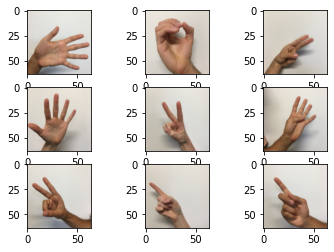

In [15]:
print("Algunos ejemplos")
for i in range(9):
  plt.subplot(331 + i)
  plt.imshow(train_x[i])
  print("Label de la imágen {}: {}".format(i, train_y[i]))

In [16]:
# Readapdo las etiquetas para que tengan formato one-hot
train_y = tf.one_hot(train_y, 10)
test_y = tf.one_hot(test_y, 10)

In [19]:
val_x = train_x[:100]
val_y = train_y[:100]
train_x = train_x[100:]
train_y = train_y[100:]

print(val_x.shape)
print(val_y.shape)
print(train_x.shape)
print(train_y.shape)

(100, 64, 64, 3)
(100, 1, 10)
(980, 64, 64, 3)
(980, 1, 10)


In [38]:
train_y = np.reshape(train_y, (980, 10, 1))
val_y = np.reshape(val_y, (100, 10, 1))
test_y = np.reshape(test_y, (120, 10, 1))

print(train_y.shape)
print(val_y.shape)
print(test_y.shape)

(980, 10, 1)
(100, 10, 1)
(120, 10, 1)


In [39]:
# Uso ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imgaug import augmenters as iaa

aug1 = iaa.GaussianBlur(sigma=(0, 2.0))
aug2 = iaa.AdditiveGaussianNoise(scale=0.02 * 255)

# Defino una función que aplica las transformaciones sobre una imágen
def additional_augmentation(image):
    image = aug1.augment_image(image)
    image = aug2.augment_image(image)
    return image

In [40]:
aug_train_datagen = ImageDataGenerator(width_shift_range=0.3,
                                       height_shift_range=0.3,
                                       brightness_range=[0.6, 1.2],
                                       zoom_range=[0.5, 1.5],
                                       horizontal_flip=True,
                                       rescale=1./255,
                                       preprocessing_function=additional_augmentation)

aug_valid_datagen = ImageDataGenerator(width_shift_range=0.3,
                                       height_shift_range=0.3,
                                       brightness_range=[0.6, 1.2],
                                       zoom_range=[0.5, 1.5],
                                       horizontal_flip=True,
                                       rescale=1./255,
                                       preprocessing_function=additional_augmentation)

test_datagen = ImageDataGenerator(rescale=1./255)

In [45]:
aug_train_generator = aug_train_datagen.flow(x=train_x,
                                             y=train_y,
                                             batch_size=32)

aug_valid_generator = aug_valid_datagen.flow(x=val_x,
                                             y=val_y,
                                             batch_size=32)

test_generator = test_datagen.flow(x=test_x,
                                   y=test_y,
                                   batch_size=32)

In [46]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(64, 64, 3)))
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 8, 8, 64)        

In [47]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])

aug_history = model.fit(aug_train_generator,
                        epochs=50,
                        validation_data=aug_valid_generator
                        )

Epoch 1/50
31/31 [==============================] - 6s 175ms/step - loss: 1.8999 - categorical_accuracy: 0.1694 - val_loss: 1.8298 - val_categorical_accuracy: 0.1800
Epoch 2/50
31/31 [==============================] - 5s 162ms/step - loss: 1.8279 - categorical_accuracy: 0.1888 - val_loss: 1.7779 - val_categorical_accuracy: 0.1800
Epoch 3/50
31/31 [==============================] - 5s 162ms/step - loss: 1.7838 - categorical_accuracy: 0.2071 - val_loss: 1.7783 - val_categorical_accuracy: 0.2200
Epoch 4/50
31/31 [==============================] - 5s 164ms/step - loss: 1.7574 - categorical_accuracy: 0.2398 - val_loss: 1.7956 - val_categorical_accuracy: 0.2000
Epoch 5/50
31/31 [==============================] - 5s 162ms/step - loss: 1.7010 - categorical_accuracy: 0.2918 - val_loss: 1.9157 - val_categorical_accuracy: 0.2200
Epoch 6/50
31/31 [==============================] - 5s 163ms/step - loss: 1.6315 - categorical_accuracy: 0.3490 - val_loss: 1.6166 - val_categorical_accuracy: 0.3900
Epoc

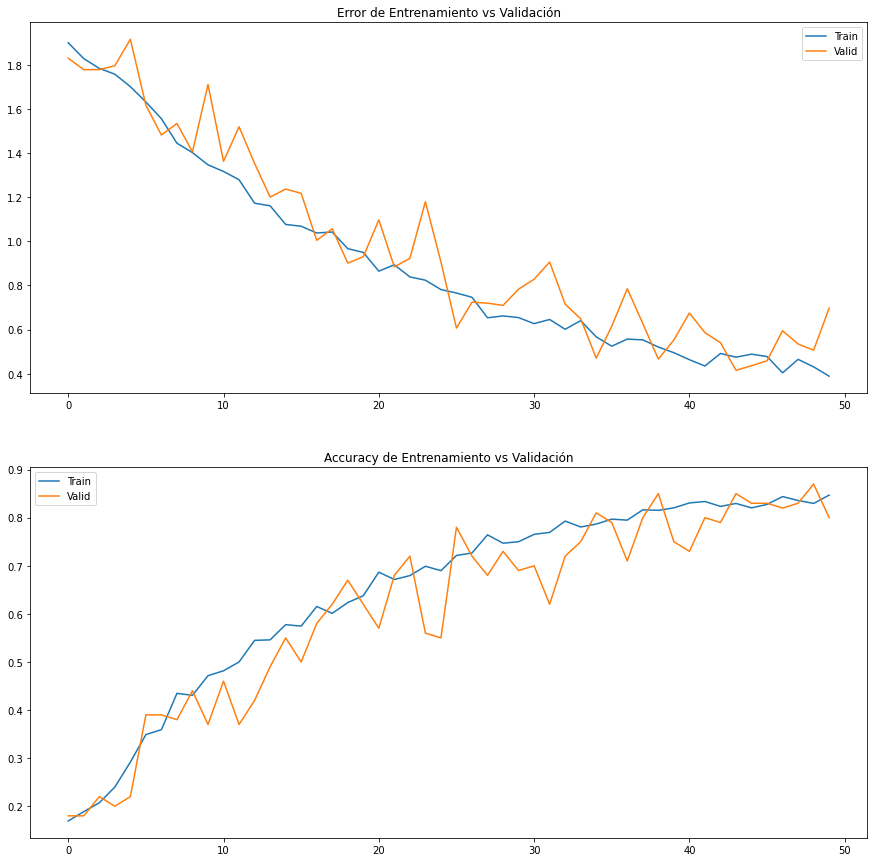

In [48]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(aug_history.history['loss']) 
axs[0].plot(aug_history.history['val_loss']) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(aug_history.history['categorical_accuracy']) 
axs[1].plot(aug_history.history['val_categorical_accuracy']) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [51]:
results = model.evaluate(test_generator)

print("El modelo logro un error de {} y una accuracy de {}".format(results[0], results[1]))

4/4 [==============================] - 0s 8ms/step - loss: 0.2606 - categorical_accuracy: 0.9500
El modelo logro un error de 0.26055940985679626 y una accuracy de 0.949999988079071
